In [ ]:
%load_ext autoreload
%autoreload 2
import pandas as pd
# feature_extract.init_group()

In [ ]:
model_string = 'dinov2_vitl14'
pairwise_distances_df = pd.read_pickle(f'collection_dist_{model_string}.pkl')

In [ ]:
# Find the row with the minimum average distance
min_distance_row = pairwise_distances_df.loc[pairwise_distances_df['Dot_Distance'].idxmax()]

# Print the row with the minimum average distance
print(min_distance_row)

In [ ]:
import networkx as nx
G = nx.from_pandas_edgelist(pairwise_distances_df, 'Label1', 'Label2', ['Dot_Distance','Euc_Distance'], create_using=nx.Graph())
# Find communities using Louvain method
partition = nx.community.louvain_communities(G, weight='Dot_Distance',resolution=1.5)

# Add community information to the graph nodes
nx.set_node_attributes(G, partition, 'community')

In [ ]:
import os
import random
from PIL import Image
import numpy as np
from tqdm import tqdm

# Replace this with the path to your main directory containing subdirectories with images
main_directory = '/global/scratch/tlundy/NFT_Research/nft_research/Dino/images/val/'
out_directory = f'/global/scratch/tlundy/NFT_Research/nft_research/Dino/grids/{model_string}'

# Function to create a 3x3 grid from randomly selected images
def create_image_grid(directories,label):
    # Select 9 directories at random
    if len(directories)<9:
        return None
    selected_directories = random.sample(directories, min(9, len(directories)))

    # Create a blank canvas for the grid
    grid_size = (3, 3)
    canvas_width = 3 * 100  # Adjust this value based on the width of your images
    canvas_height = 3 * 100  # Adjust this value based on the height of your images
    canvas = Image.new('RGB', (canvas_width, canvas_height), 'white')

    # Iterate over selected directories
    for i, directory in enumerate(selected_directories):
        # Get a list of all image files in the directory
        image_files = [f for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.png')]

        # Select one random image from the directory
        if image_files:
            selected_image = random.choice(image_files)
            img_path = os.path.join(directory, selected_image)
            img = Image.open(img_path)
            img = img.resize((100, 100))  # Adjust this size based on your preference
            row = i // grid_size[1]
            col = i % grid_size[1]
            canvas.paste(img, (col * 100, row * 100))

    # Save or display the resulting grid image
    canvas.save(os.path.join(out_directory, f'{label}_grid_image.jpg'))
    # canvas.show()

# Iterate over each subdirectory and create a grid image
for comm in tqdm(partition):
    comm = list(comm)
    subdirectories = [os.path.join(main_directory, x) for x in comm if os.path.isdir(os.path.join(main_directory, x))]
    create_image_grid(subdirectories,comm[0])

In [ ]:
merged_df2 = pd.read_pickle(f'collection_features_{model_string}.pkl')
label_to_vec = merged_df2.set_index('FileName')['AverageFeatureVector'].to_dict()
del merged_df2

In [ ]:
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster
import matplotlib.pyplot as plt
data = list(label_to_vec.values())
labels = list(label_to_vec.keys())


# Perform hierarchical clustering
Z = linkage(data, method='complete')
# Plot dendrogram
clusters = fcluster(Z, t=1.1, criterion='distance')

In [ ]:
file_to_cluster = {}
for i,key in enumerate(labels):
    file_to_cluster[key] =clusters[i]
df = pd.DataFrame.from_dict(file_to_cluster, orient='index', columns=['Cluster']).reset_index()


In [ ]:
grouped = df.groupby('Cluster')['index']
main_directory = '/global/scratch/tlundy/NFT_Research/nft_research/Dino/images/val/'
out_directory = f'/global/scratch/tlundy/NFT_Research/nft_research/Dino/grids/{model_string}/cluster/'
# Iterate through groups
for value, keys in grouped:
    if len(keys)<9:
        continue
    subdirectories = [os.path.join(main_directory, x) for x in keys if os.path.isdir(os.path.join(main_directory, x))]
    create_image_grid(subdirectories,list(keys)[0])

In [ ]:
import sys
sys.path.append("..")
from Openseas_Methods import *
contracts = []
for label in tqdm(labels):
    contracts.append(pull_nft_contracts(label,no_save=True))

In [ ]:
import requests
label_to_owners = {}

for label,contract in tqdm(contracts):
    url = f"https://eth-mainnet.g.alchemy.com/nft/v3/-dkhE3R5RIFr9b9KUhpp4pqlQFzpPFzW/getOwnersForContract?contractAddress={contract}&withTokenBalances=false"
    headers = {"accept": "application/json"}
    response = requests.get(url, headers=headers)
    try:
        label_to_owners[label] = response.json()['owners']
    except:
        print(f'Error on label {label}')

In [ ]:
from itertools import chain
flattened_list = list(chain(*list(label_to_owners.values())))

In [ ]:
len(set(flattened_list))/len(flattened_list)

In [ ]:
size = []
wall_count = []
plt_labels = []
for comm in tqdm(partition):
    comm = list(comm)
    addresses = []
    if len(comm)<9:
        continue
    print(comm[0])
    for coll in comm:
        try:
            addresses+=label_to_owners[coll]
        except:
            continue
    wall_count.append(len(set(addresses))/len(addresses))
    size.append(len(comm))
    plt_labels.append(comm[0])

In [ ]:
import pickle
with open('coll_to_owners.pkl','wb') as f:
    pickle.dump(label_to_owners,f)

In [ ]:
grouped = df.groupby('Cluster')['index']
size = []
wall_count = []
plt_labels = []
for value, keys in grouped:
    addresses = []
    if len(keys)<9:
        continue
    print(list(keys)[0])
    for coll in keys:
        try:
            addresses+=label_to_owners[coll]
        except:
            continue
    print(len(set(addresses))/len(addresses))
    wall_count.append(len(set(addresses))/len(addresses))
    size.append(len(keys))
    plt_labels.append(list(keys)[0])

In [ ]:
# data_points = []
# for x in tqdm(range(1,1000)):
#     stats = []
#     for y in range(0,10):
#         addresses = []
#         colls = random.choices(labels,k=x)
#         for coll in colls:
#             try:
#                 addresses+=label_to_owners[coll]
#             except:
#                 continue
#         stats.append(len(set(addresses))/len(addresses))
#     data_points.append(sum(stats)/len(stats))
# Plotting the line
print(len(size))
print(len(wall_count))
plt.plot(data_points)
plt.scatter(size,wall_count,color='orange')
# for label, x, y in zip(plt_labels, size, wall_count):
#     plt.text(x, y, label, ha='right', va='bottom')
# Adding labels and title (optional)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Line Plot of Values')
# Display the plot
plt.show()

In [184]:
crude_comm = [x for x in partition if 'crudeborne-crudelings' in x]
milady_comm= [x for x in partition if 'milady' in x]
milady_comm= [x for x in partition if 'boredapeyachtclub' in x]

In [189]:
list(milady_comm[0])[0]

'jimmys-clubhouse'

In [ ]:
from itertools import combinations
curr_overlap = 1
ov_set = []
for x in combinations(list(milady_comm[0]),5):
    addresses = []
    # print(x)
    for y in x:
        addresses+=label_to_owners[y]
    overlap = len(set(addresses))/len(addresses)
    # print(overlap)
    if overlap<curr_overlap:
        curr_overlap=overlap
        ov_set = x
print(curr_overlap)
print(ov_set)

In [ ]:
local_prob = []
plt_labels = []
total_walls = len(set(flattened_list))
idx = 0
for comm in tqdm(partition):
    comm = list(comm)
    addresses = []
    if len(comm)<9:
        continue
    print(comm[0])
    for coll in comm: 
        comm_sub = [x for x in comm if x!=coll]
        address_sub = []
        for coll2 in comm_sub:
            try:
                address_sub+=label_to_owners[coll2]
            except:
                continue
        addy_set = set(address_sub)
        try:
            coll_set = set(label_to_owners[coll])
        except:
            continue
        global_prob = (len(coll_set)/total_walls)
        pred = len(addy_set.intersection(coll_set))/len(addy_set)
        local_prob.append((coll,pred,global_prob,idx,comm[0]))
    plt_labels.append(comm[0])
    idx+=1

In [ ]:
print(local_prob)

In [ ]:
local = [x[1] for x in local_prob]
global_p = [x[2] for x in local_prob]
plt.scatter(local,global_p)
plt.xlabel('Conditional Probability')
plt.ylabel('Global Probability')
plt.plot(np.linspace(min(local), max(local), 100), np.linspace(min(local), max(local), 100), color='red', linestyle='--', label='x=y Line')
plt.legend()

In [ ]:
sorted_tuples = sorted(local_prob, key=lambda x: x[2],reverse=True)
print(sorted_tuples)

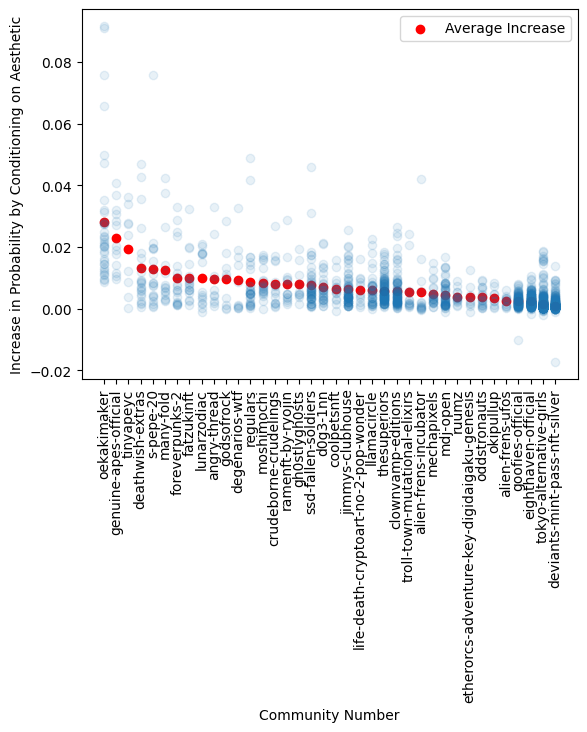

In [181]:
ratio = [(x[1]-x[2]) for x in local_prob if x[2]!=0]
labels = [x[4] for x in local_prob if x[2]!=0]
label_to_avg = {}
for label in set(labels):
    avg = np.mean([(x[1]-x[2]) for x in local_prob if x[2]!=0 and x[4]==label])
    label_to_avg[label] = avg
sorted_labels = sorted(label_to_avg.keys(), key=lambda label: label_to_avg[label],reverse=True)
for i,label in enumerate(sorted_labels):
    if i==1:
        plt.scatter(label, label_to_avg[label], marker='o', color='red', label='Average Increase')
    else:
        plt.scatter(label, label_to_avg[label], marker='o', color='red')
plt.legend()
plt.xlabel('Community Number')
plt.xticks(rotation='vertical')
plt.ylabel('Increase in Probability by Conditioning on Aesthetic')
plt.scatter(labels,ratio,alpha=0.1)

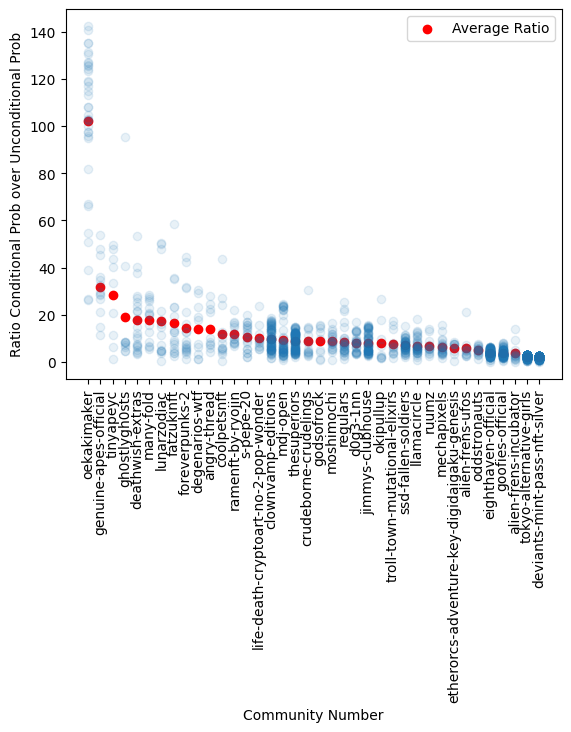

In [183]:
ratio = [(x[1]/x[2]) for x in local_prob if x[2]!=0]
labels = [x[4] for x in local_prob if x[2]!=0]
label_to_avg = {}
for label in set(labels):
    avg = np.mean([(x[1]/x[2]) for x in local_prob if x[2]!=0 and x[4]==label])
    label_to_avg[label] = avg
sorted_labels = sorted(label_to_avg.keys(), key=lambda label: label_to_avg[label],reverse=True)
for i,label in enumerate(sorted_labels):
    if i==1:
        plt.scatter(label, label_to_avg[label], marker='o', color='red', label='Average Ratio')
    else:
        plt.scatter(label, label_to_avg[label], marker='o', color='red')
plt.legend()
plt.xlabel('Community Number')
plt.xticks(rotation='vertical')
plt.ylabel('Ratio Conditional Prob over Unconditional Prob')
plt.scatter(labels,ratio,alpha=0.1)